In [ ]:
cd ..

In [ ]:
import pandas as pd
from tqdm.auto import tqdm
from skimpy import skim
import matplotlib.pyplot as plt
import plotly.express as px
import re
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from concurrent.futures import ThreadPoolExecutor
import math
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
tqdm.pandas()
nltk.download('stopwords')

In [18]:
data_complaints = pd.read_csv('complaints_cleaned.csv')

##  Visualisons la distribution de la longueur des textes cette fois-ci pour chaque classe
## On utilisera lebox plot qui permet de voir les quartiles ainsi que les valeurs aberrantes

In [10]:
data_complaints['word_count'] = data_complaints['text'].apply(lambda x: len(str(x).split()))
data_complaints

,text,label,word_count
0,contact alli friday xx xx xxxx fall behind pay...,Vehicle loan or lease,161
1,capit one auto financ incorrect without notic ...,"Credit reporting, credit repair services, or o...",55
2,hello complaint three credit report companies....,"Credit reporting, credit repair services, or o...",213
3,victim ident theft current experian account vi...,"Credit reporting, credit repair services, or o...",129
4,two account still credit histori contact credi...,"Credit reporting, credit repair services, or o...",19
...,...,...,...
830202,autom call xxxx capit one '' call home phone e...,Credit card,43
830203,disput debt sever time resolution. submit pape...,Debt collection,14
830204,"father die xx xx xxxx. left son belongings, al...",Mortgage,300
830205,cfbp would like file complaint experian report...,Credit reporting,76


## Analysons la distribution de la longueur du texte pour chaque classe avec un boxplot (boite à moustache)

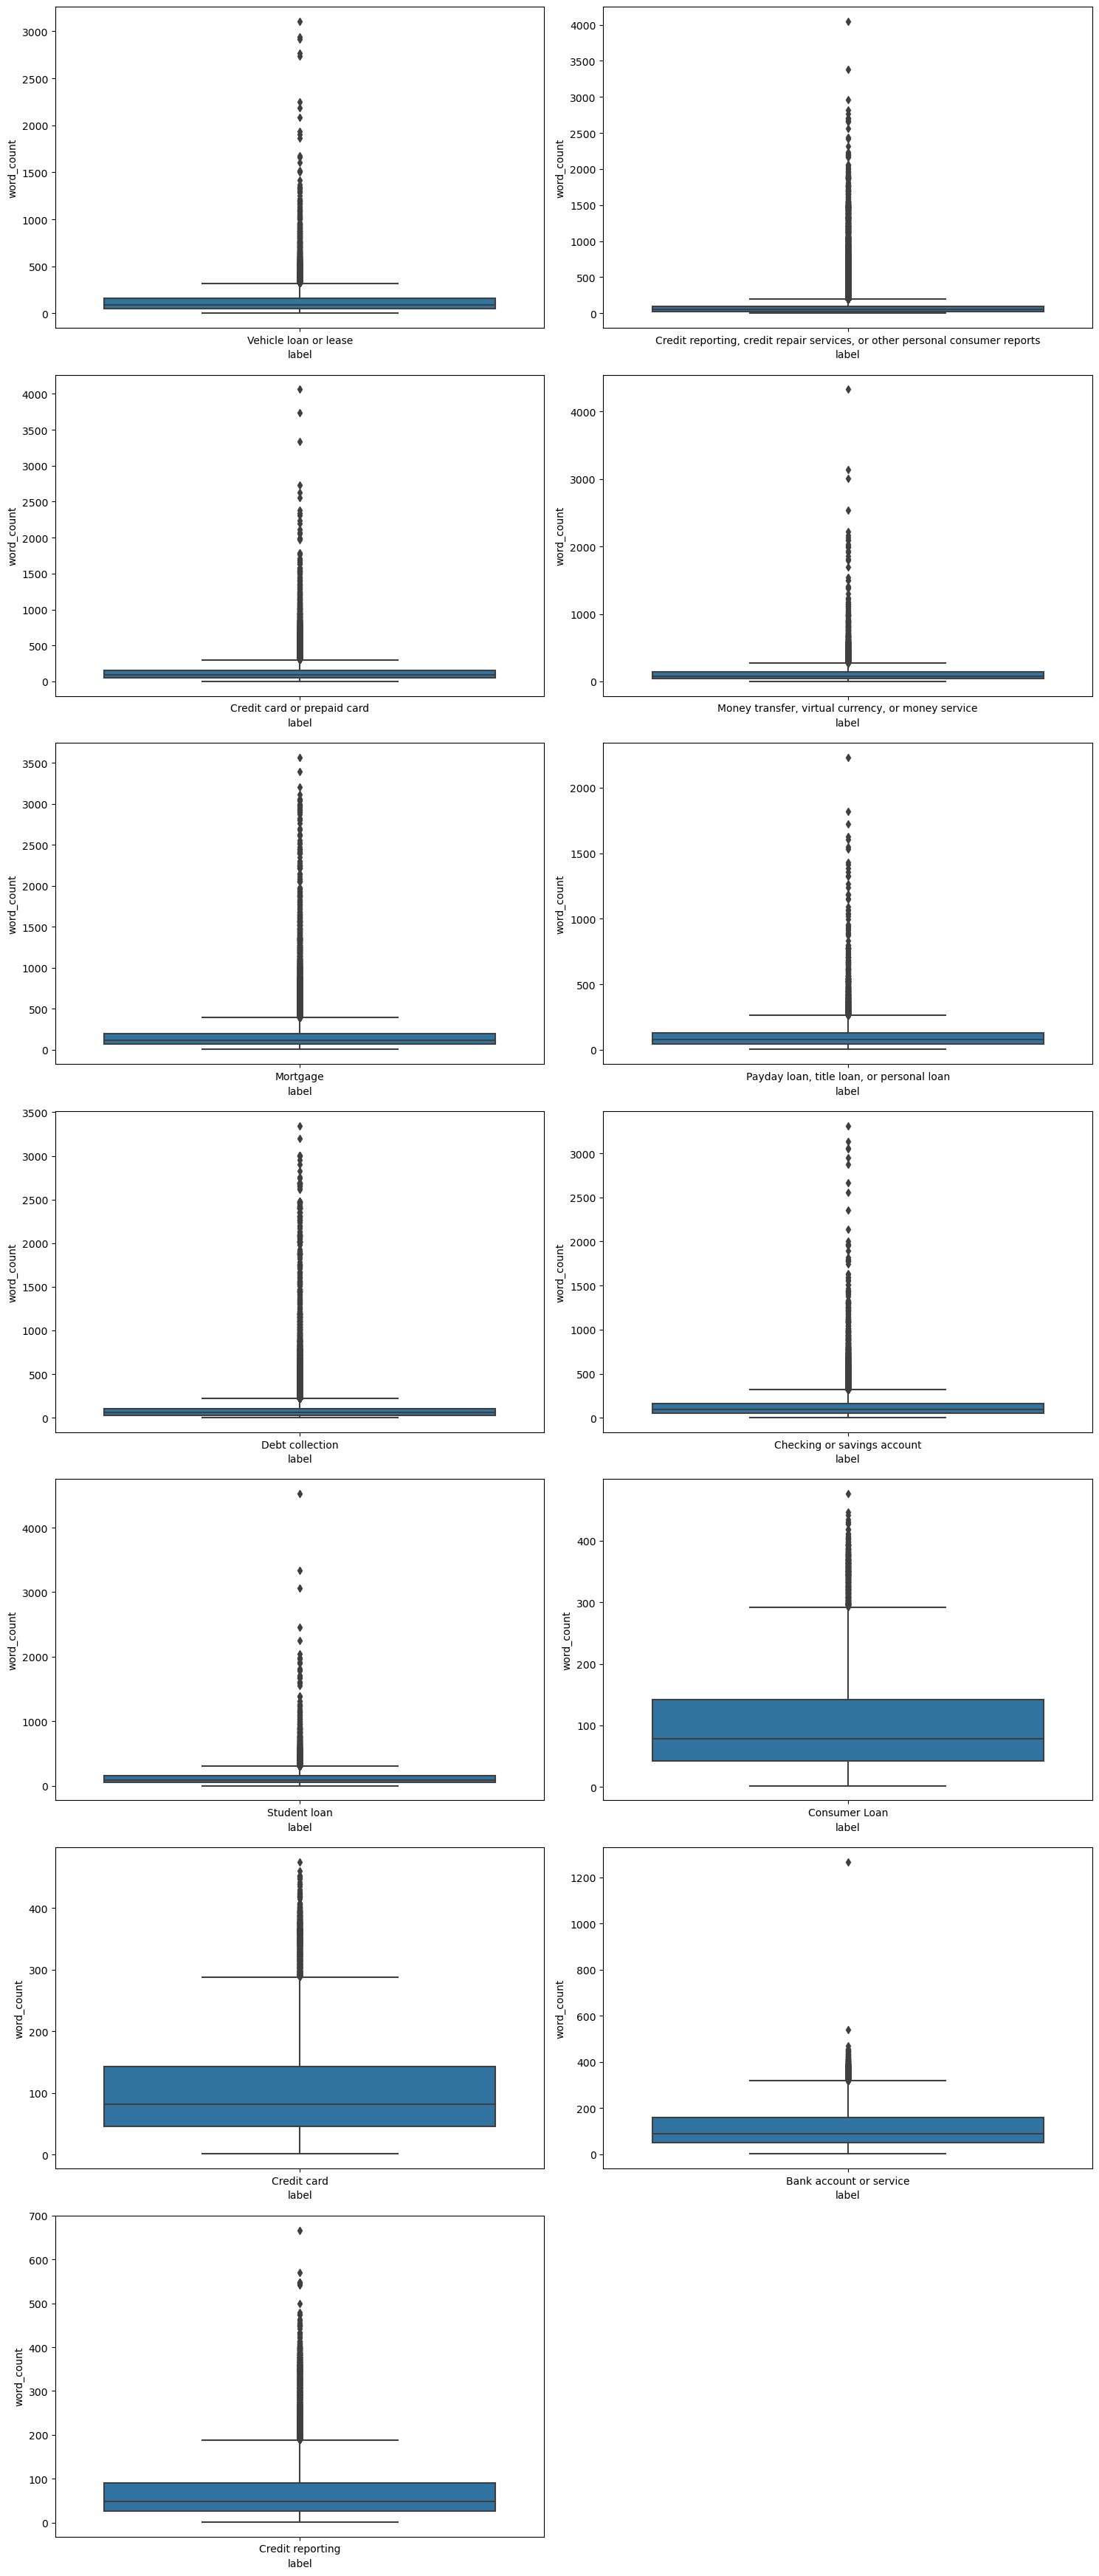

In [7]:
unique_labels = data_complaints['label'].unique()
n_labels = len(unique_labels)

n_cols = 2
n_rows = (n_labels + 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, n_rows*5))

axs = axs.flatten()

for i, label in enumerate(unique_labels):
    subset = data_complaints[data_complaints['label'] == label]
    sns.boxplot(ax=axs[i], data=subset, x='label', y='word_count')

for i in range(n_labels, n_rows*n_cols):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()


## La mediane est approximativement la meme pour chaque label

## On voit qu'il y'a des valeurs aberrantes, certains textes ont des valeurs supérieurs à 4000 de taille (selon le .split())
## On pourrai ausssi calculer la longueur grace à des tokens d'un Tokenizer pre entrainé


## Identifions les valeurs aberrantes avec la methode de l'intervalle inter-quartile IQR

In [48]:
Q1 = data_complaints['word_count'].quantile(0.25)
Q3 = data_complaints['word_count'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identification des valeurs aberrantes
outliers = data_complaints[data_complaints['word_count'] > upper_bound]
outliers['text'].iloc[3]


"ran credit report via xxxx xx xx xxxx work hard repair credit past mistakes. review it, came realiz xxxx xxxx run soft inquiri credit non stop last two years. say non stop, exaggeration. pretti much week last two year straight. stress next statement enough ... never appli sort credit xxxx xxxx entir life. once. credit card, busi credit card, loan, anything. attempt contact inform put stop got absolut nowhere. outsourc custom servic repeat ask social secur number aka last thing world would give phone order look '. offer piec inform help put end supervisor xxxx xxxx told can't help you. go file complaint credit bureaus '. ... i'm furious. exact inform found xxxx credit report ran xx xx xxxx soft inquiri '' section relat issu ... xxxx xxxx inquir xx xx xxxx, xx xx xxxx, xx xx xxxx, xx xx xxxx, xx xx xxxx, xx xx xxxx, xx xx xxxx, xx xx xxxx, xx xx xxxx, xx xx xxxx, xx xx xxxx, xx xx xxxx, xx xx xxxx, xx xx xxxx, xx xx xxxx, xx xx xxxx, xx xx xxxx, xx xx xxxx, xx xx xxxx, xxxx, xx xx xxxx,

## On voit que les valeurs aberrantes contiennent des sequences de xx...x souvent, analysons cela de plus pres avec la fréquence des xx...x dans chaque text

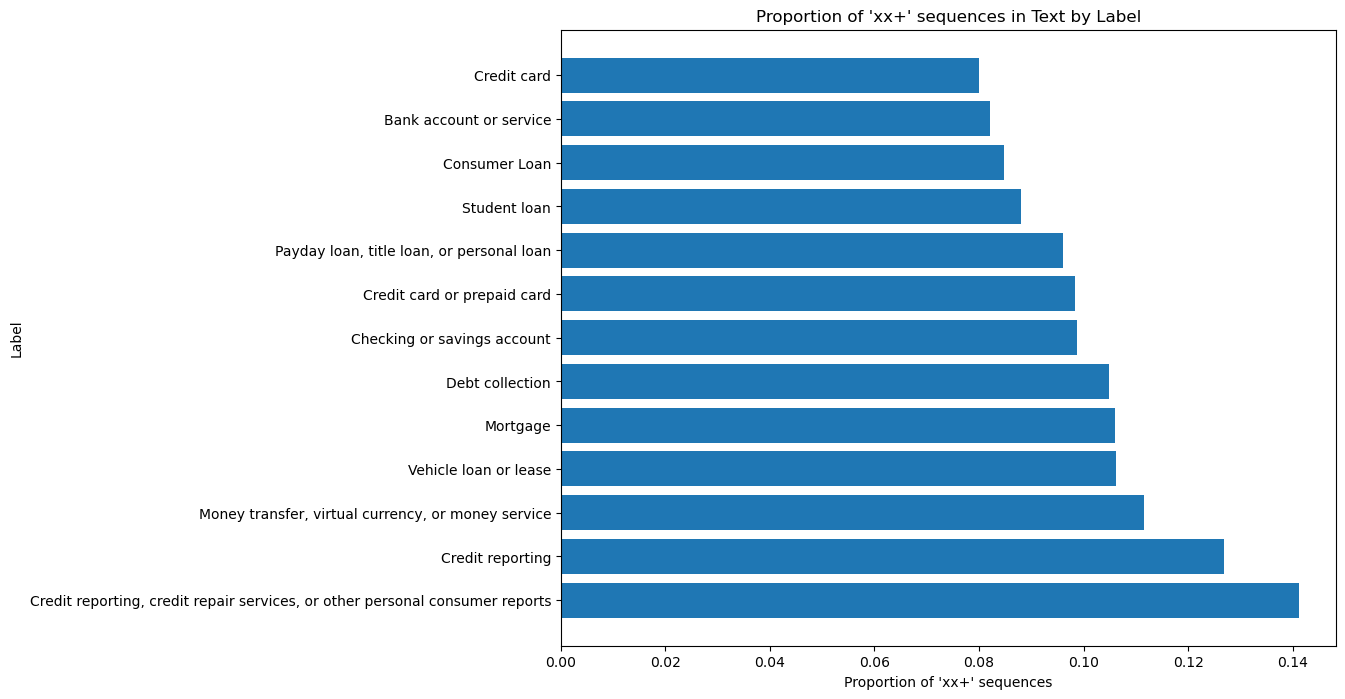

In [49]:
def visualize_x_proportion(data):
    
    data_complaints['x_sequence_count'] = data['text'].apply(lambda text: len(re.findall(r'xx+', text)))
    data_complaints['x_proportion'] = data['x_sequence_count'] / data['word_count']
    proportions_by_label = data.groupby('label')['x_proportion'].mean().reset_index()
    proportions_by_label_sorted = proportions_by_label.sort_values(by='x_proportion', ascending=False)
    
    plt.figure(figsize=(10, 8))
    plt.barh(proportions_by_label_sorted['label'], proportions_by_label_sorted['x_proportion'])
    plt.xlabel('Proportion of \'xx+\' sequences')
    plt.ylabel('Label')
    plt.title('Proportion of \'xx+\' sequences in Text by Label')
    plt.show()

visualize_x_proportion(data_complaints)

## Certains label ont plus de 10% de sequences 'xx...x' dans leur texte, on les enleve.

In [11]:
def remove_xxx(text):
    # Remplacer les occurrences de 'xxx...x' avec une expression régulière
    return re.sub(r'\bx{2,}\b', '', text)
data_complaints['text'] = data_complaints['text'].apply(remove_xxx)

In [12]:
data_complaints.to_csv('./complaints_cleaned_xxx.csv')

# Exploration des mots clés :

## Les classes sont trés désequilibrés, voyant l'impact de ce desequilibre en comparant 2 méthodes : une qui ne prend pas en compte ce desequilibrage et une qui le prend en compte

## Encodons deja les labels : on utilisera le one-hot encoding


In [13]:
def one_hot_encode_labels(data):
    
    data = pd.concat([data, pd.get_dummies(data['label'], prefix='label', dtype=int)], axis=1)
    return data

data_complaints = one_hot_encode_labels(data_complaints)


In [14]:
data_complaints

,text,label,word_count,label_Bank account or service,label_Checking or savings account,label_Consumer Loan,label_Credit card,label_Credit card or prepaid card,label_Credit reporting,"label_Credit reporting, credit repair services, or other personal consumer reports",label_Debt collection,"label_Money transfer, virtual currency, or money service",label_Mortgage,"label_Payday loan, title loan, or personal loan",label_Student loan,label_Vehicle loan or lease
0,contact alli friday fall behind payment due...,Vehicle loan or lease,161,0,0,0,0,0,0,0,0,0,0,0,0,1
1,capit one auto financ incorrect without notic ...,"Credit reporting, credit repair services, or o...",55,0,0,0,0,0,0,1,0,0,0,0,0,0
2,hello complaint three credit report companies....,"Credit reporting, credit repair services, or o...",213,0,0,0,0,0,0,1,0,0,0,0,0,0
3,victim ident theft current experian account vi...,"Credit reporting, credit repair services, or o...",129,0,0,0,0,0,0,1,0,0,0,0,0,0
4,two account still credit histori contact credi...,"Credit reporting, credit repair services, or o...",19,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830202,autom call capit one '' call home phone exces...,Credit card,43,0,0,0,1,0,0,0,0,0,0,0,0,0
830203,disput debt sever time resolution. submit pape...,Debt collection,14,0,0,0,0,0,0,0,1,0,0,0,0,0
830204,"father die . left son belongings, also singl...",Mortgage,300,0,0,0,0,0,0,0,0,0,1,0,0,0
830205,cfbp would like file complaint experian report...,Credit reporting,76,0,0,0,0,0,1,0,0,0,0,0,0,0


## 1) TF IDF sans pondération du desequilibre :

## Je vais utiliser le TF IDF pour vectorizer le texte et extraire les mots clés importants dans chaque text:
### Term Frequency (TF)

La fréquence d'un terme est calculée comme le nombre de fois qu'un terme apparaît dans un document par rapport au nombre total de termes dans ce document :

$$
TF(t, d) = \frac{\text{Nombre de fois que le terme } t \text{ apparaît dans le document } d}{\text{Nombre total de termes dans le document } d}
$$

### Inverse Document Frequency (IDF)

L'inverse de la fréquence documentaire mesure l'importance d'un terme. Plus un terme est rare, plus son score IDF est élevé, ce qui augmente l'importance du terme :

$$
IDF(t, D) = \log \left(\frac{\text{Nombre total de documents } D}{\text{Nombre de documents où le terme } t \text{ apparaît} + 1 }\right)
$$

Notez l'ajout de `1` dans le dénominateur pour éviter une division par zéro si le terme n'apparaît dans aucun document.

### Calcul de TF-IDF

La valeur TF-IDF est simplement le produit des deux statistiques précédentes pour un terme donné dans un document :

$$
TFIDF(t, d, D) = TF(t, d) \times IDF(t, D)
$$

Cette valeur est utilisée pour évaluer l'importance relative d'un mot par rapport à un document dans un ensemble de documents ou un corpus. Plus la valeur de TF-IDF est élevée, plus le terme est considéré comme significatif pour ce document.
## On pourra visualiser cela en utilisant un nuage de mots WordCloud

In [29]:
def visualize_keywords(data):
    
    tfidf = TfidfVectorizer(max_df=0.95, min_df=10, max_features=1000, ngram_range=(1, 1))
    
    dtm = tfidf.fit_transform(data['text'])
    
    label_columns = [col for col in data if col.startswith('label_')]
    
    tfidf_df = pd.DataFrame.sparse.from_spmatrix(dtm, columns=tfidf.get_feature_names_out())
    
    def get_top_keywords(n_terms):
        dfs = []
        for label in label_columns:
            
            weighted_scores = tfidf_df.multiply(data[label], axis=0)
            mean_scores = weighted_scores.mean(axis=0).nlargest(n_terms)
            temp = pd.DataFrame(mean_scores).reset_index()
            temp.columns = ['term', 'score']
            temp['label'] = label
            dfs.append(temp)
        return pd.concat(dfs, ignore_index=True)

    keywords = get_top_keywords(5)
    
    n_labels = len(label_columns)
    n_cols = min(4, n_labels)
    n_rows = n_labels // n_cols + (n_labels % n_cols > 0)
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 5 * n_rows))
    axs = axs.flatten() if n_labels > 1 else [axs]
    
    for i, label in enumerate(label_columns):
        wc = WordCloud(background_color='white', max_words=10)
        label_data = keywords[keywords['label'] == label]
        wc.generate_from_frequencies(dict(zip(label_data.term, label_data.score)))
        axs[i].imshow(wc, interpolation='bilinear')
        axs[i].axis('off')
        axs[i].set_title(label.replace('_', ' ').title())
    
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')
        
    plt.tight_layout(pad=1.0, w_pad=0.5)  
    plt.show()



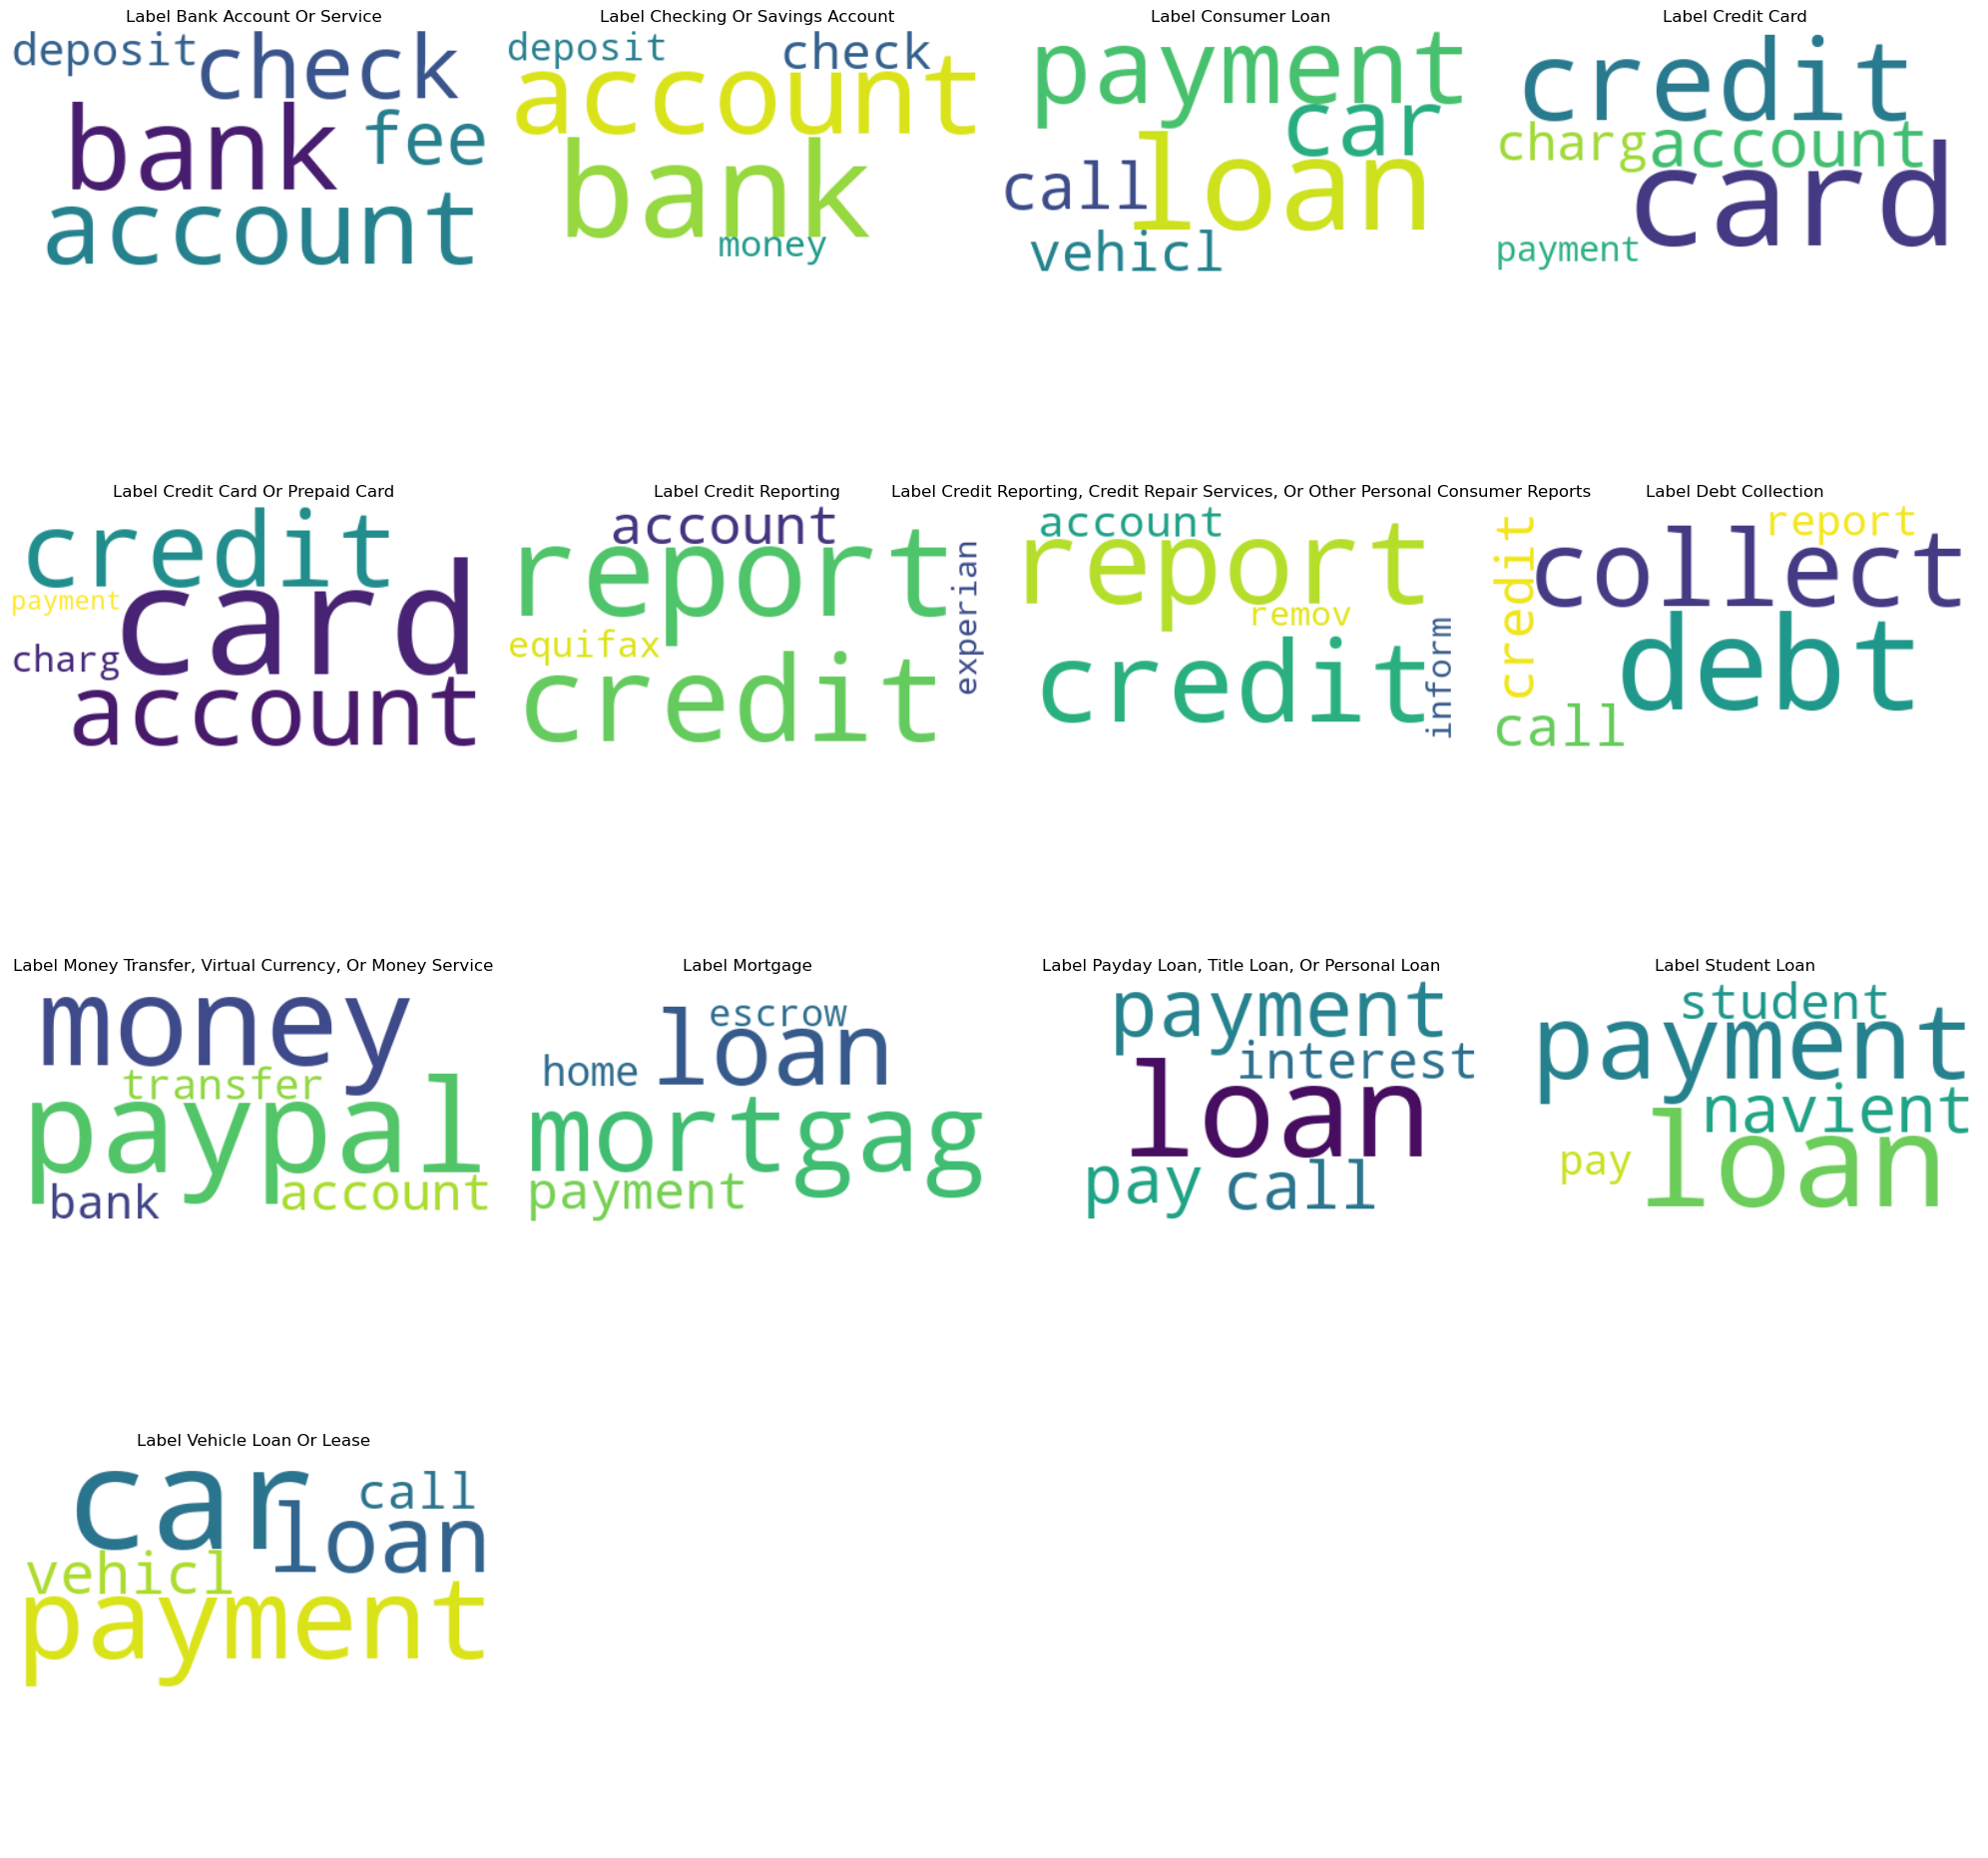

In [30]:
visualize_keywords(data_complaints)

## Les mots account, payment, apparaisent dans pusieurs labels
## le mot credit apparait uniquement dans 2 labels


# 2) TF IDF avec ponderation des scores pour le desequilibre :

## On va modifier un peu le TF IDF pour ponderer les scores calculés par la taille de chaque classe
## Donc les classes avec une petite taille seront mieux représentées ( division par un nombre plus petit )
## $$ \text{TFIDF Ponderé }(t, d, D) = \frac{TFIDF(t, d, D)}{\text{Nombre de données dans la classe correspondante}} $$


In [15]:

def visualize_keywords_ponderated(data):
    
    tfidf = TfidfVectorizer(max_df=0.95, min_df=10, max_features=1000, ngram_range=(1, 1))
    dtm = tfidf.fit_transform(data['text'])
    label_columns = [col for col in data if col.startswith('label_')]
    
    # Transformer la matrice TF-IDF en DataFrame sparse
    tfidf_df = pd.DataFrame.sparse.from_spmatrix(dtm, columns=tfidf.get_feature_names_out())
    
    # Calculer le poids de chaque label basé sur son inverse de fréquence
    label_weights = {label: 1.0 / data[label].sum() for label in label_columns}
    
    def get_top_keywords(n_terms):
        dfs = []
        for label in label_columns:
            # Poids du label spécifique
            weight = label_weights[label]
            
            # Calculer les scores pondérés
            weighted_scores = tfidf_df.multiply(data[label] * weight, axis=0)
            mean_scores = weighted_scores.mean(axis=0).nlargest(n_terms)
            temp = pd.DataFrame(mean_scores).reset_index()
            temp.columns = ['term', 'score']
            temp['label'] = label
            dfs.append(temp)
        return pd.concat(dfs, ignore_index=True)

    keywords = get_top_keywords(5)
    
    n_labels = len(label_columns)
    n_cols = min(4, n_labels)
    n_rows = n_labels // n_cols + (n_labels % n_cols > 0)
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 5 * n_rows))
    axs = axs.flatten() if n_labels > 1 else [axs]
    
    for i, label in enumerate(label_columns):
        wc = WordCloud(background_color='white', max_words=10)
        label_data = keywords[keywords['label'] == label]
        wc.generate_from_frequencies(dict(zip(label_data.term, label_data.score)))
        axs[i].imshow(wc, interpolation='bilinear')
        axs[i].axis('off')
        axs[i].set_title(label.replace('_', ' ').title())
    
    # Assurer que les subplots supplémentaires ne s'affichent pas
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')
    
    plt.tight_layout(pad=1.0, w_pad=0.5)
    plt.show()


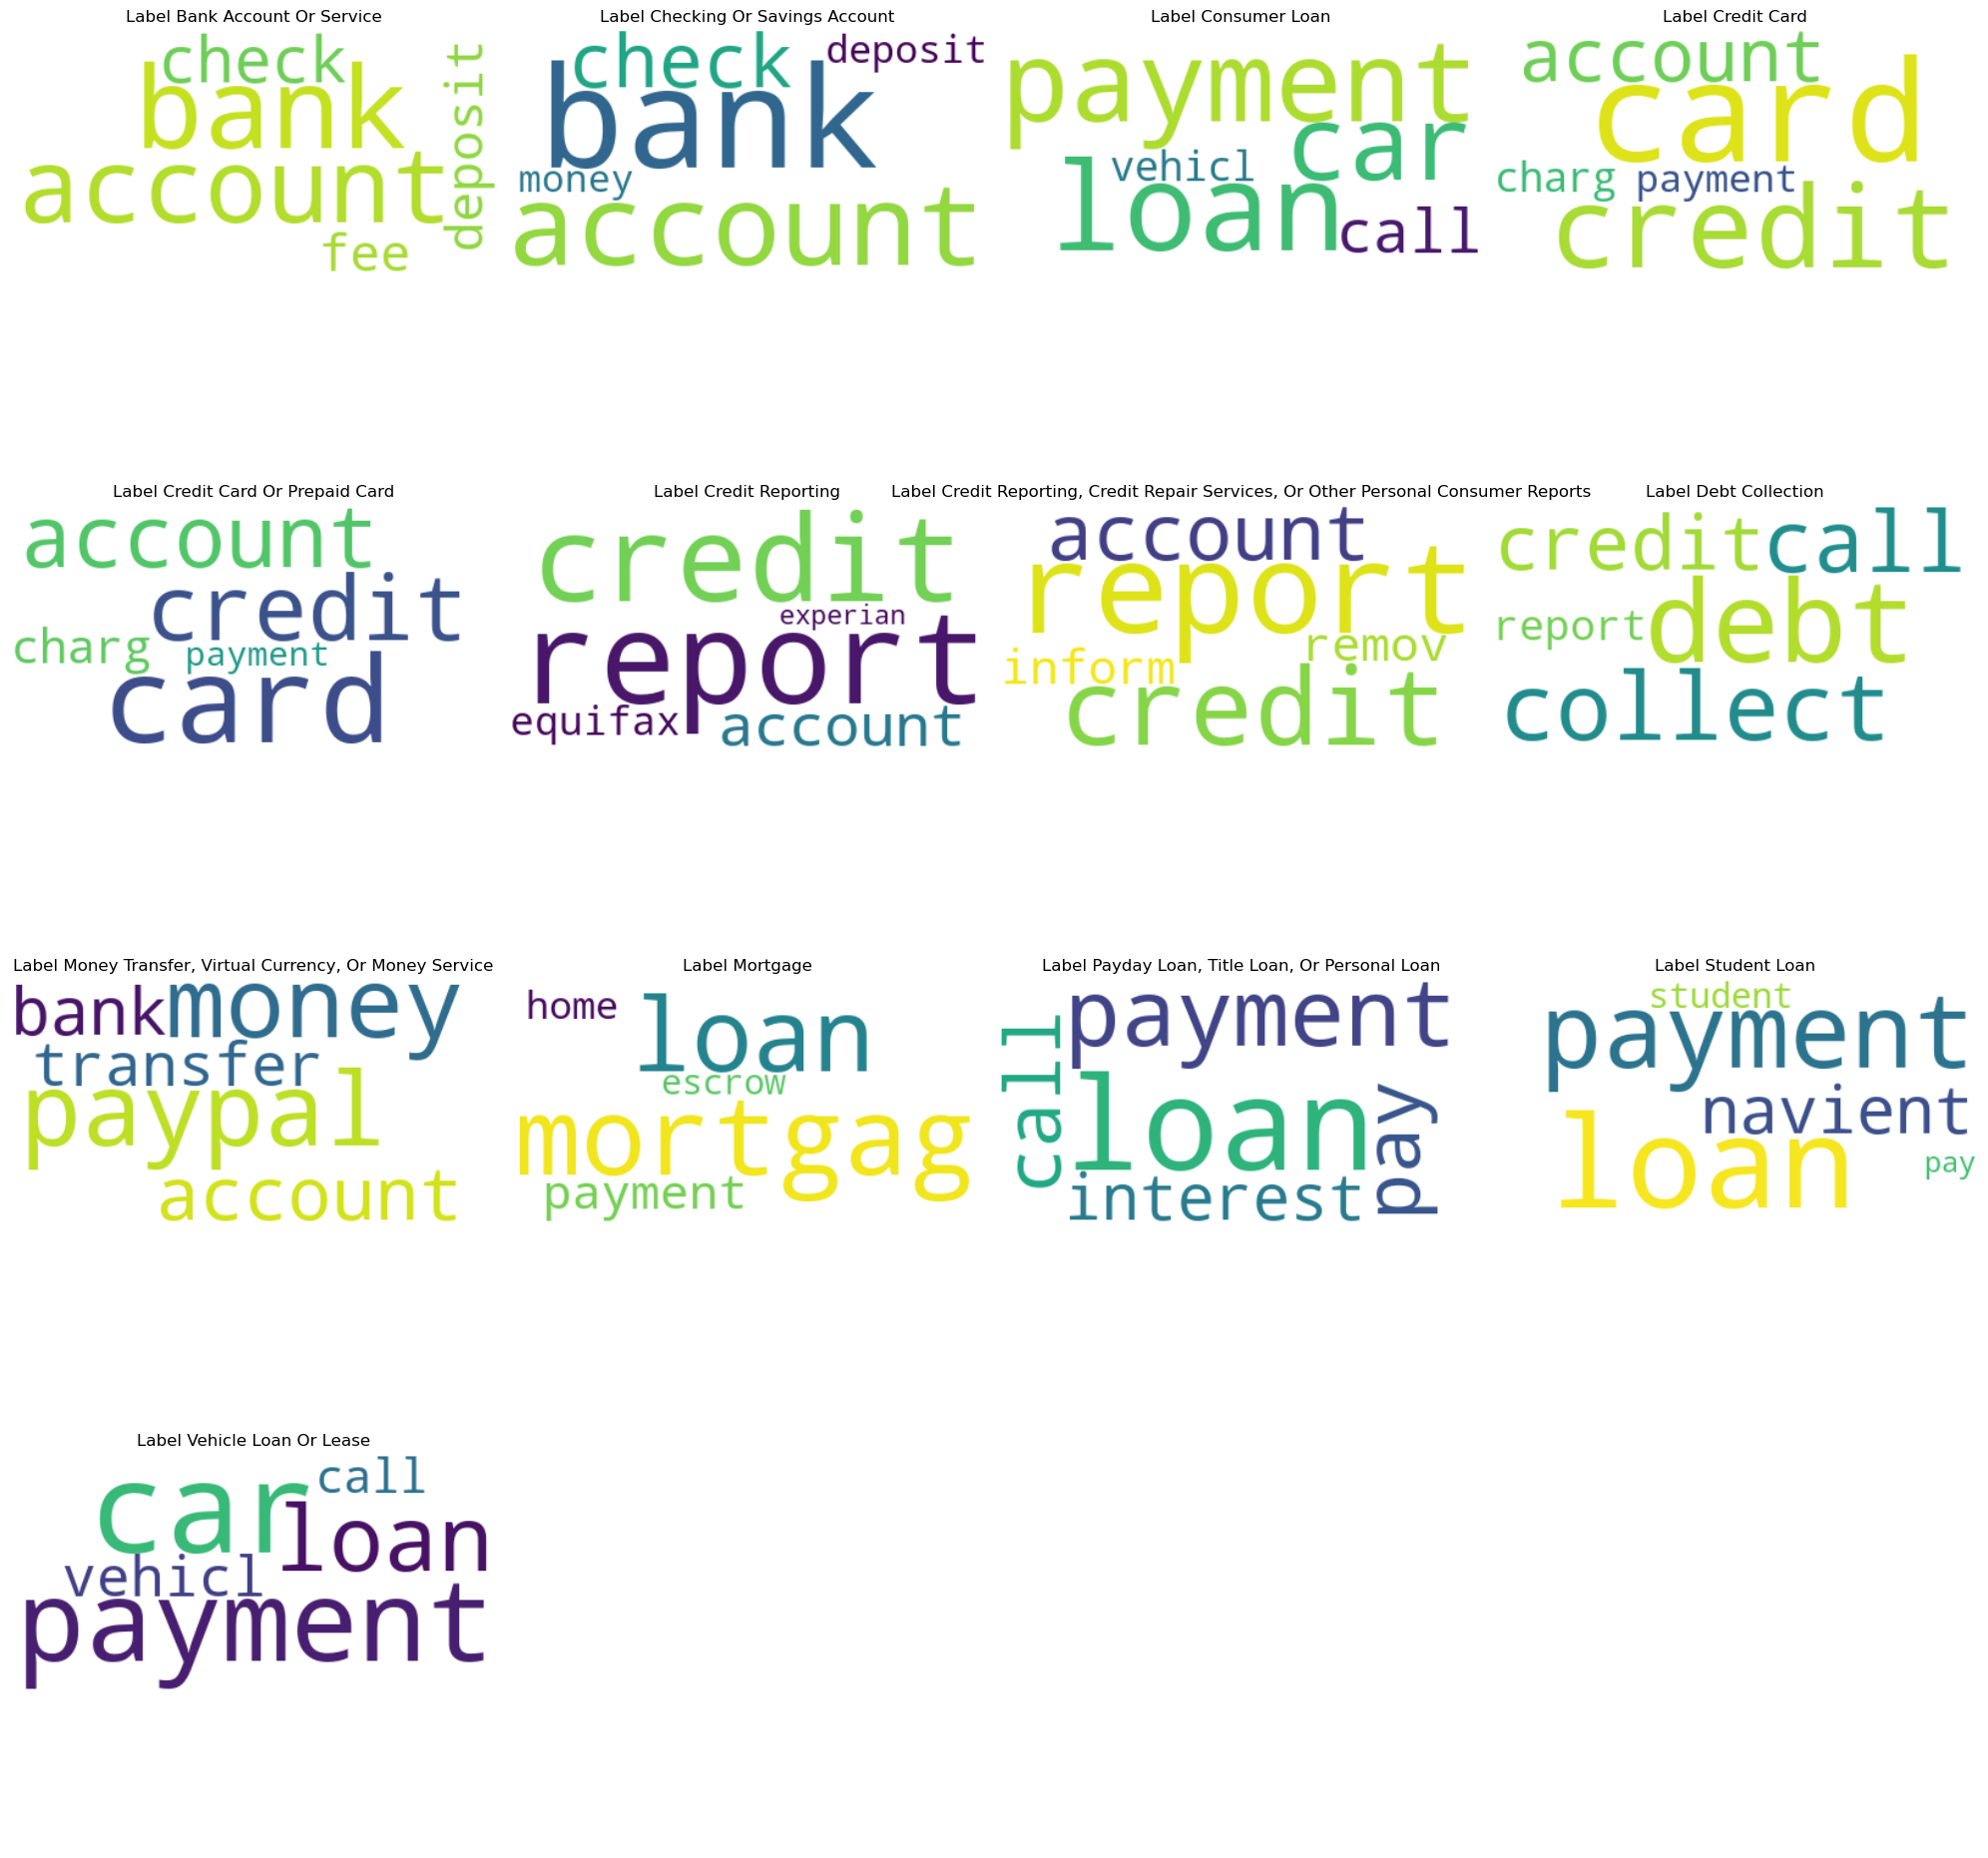

In [16]:
visualize_keywords_ponderated(data_complaints)

## Les mots clés sont les memes dans les 2 méthodes
## On pourrai dire que ces mots clés sont significatifs et robustes à l'influence du désequilibre des classes


## Examinons un peu plus les mots uniques a un label qui peuvent etre discriminants dans le modèle à utiliser :

## On va utiliser une methode naive, on va stocker les mots qui ne se repetent pas souvent dans la visualisation précedente

In [ ]:
mots_discriminants = ['fee', 'check', 'car', 'vehicl', 'credit', 'card', 'report', 'equifax', 'experian', 'debt', 'collect', 'transfer', 'money', 'paypal', 'mortgag', 'home', 'interest', 'payday', 'student', 'navient']


## On pourra enrichir notre espace de dimensions (feature space) avec la présence significative/ou non de chacun de ces mots dans un text
## On l'utilisera comme comparatif dans un deuxieme temps afin de voir la valeur ajouté de cela